In [7]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
!pip install np-utils
import np_utils
%matplotlib inline
print('TensorFlow Version:', tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np-utils: filename=np_utils-0.6.0-py3-none-any.whl size=56437 sha256=67e2ca28deb16670c4e93bdd753d77bde1a82077d137deec2e8de12f74e8dd67
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np-utils
TensorFlow Version: 2.17.0


In [8]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]

        self.W = {}
        self.b = {}

        self.dW = {}
        self.db = {}

        self.setup()

    def setup(self):
        for i in range(1, self.L):
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], self.layers[i-1])))
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i], 1)))


In [9]:
class NeuralNetwork(NeuralNetwork):
    def forward_pass(self, A):
        A = tf.convert_to_tensor(A, dtype=tf.float32)
        for i in range(1, self.L):
            Z = tf.matmul(A, tf.transpose(self.W[i])) + tf.transpose(self.b[i])
            if i != self.L-1:
                A = tf.nn.relu(Z)
            else:
                A = Z
        return A

In [10]:
class NeuralNetwork(NeuralNetwork):
    def compute_loss(self, A, Y):
        return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(Y, A))

    def update_params(self, lr):
        for i in range(1, self.L):
            self.W[i].assign_sub(lr * self.dW[i])
            self.b[i].assign_sub(lr * self.db[i])

In [11]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A), axis=1)

    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

In [12]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A, Y)
        for key in self.W.keys():
            self.dW[key] = tape.gradient(loss, self.W[key])
            self.db[key] = tape.gradient(loss, self.b[key])
        del tape
        self.update_params(lr)

        return loss.numpy()

In [13]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        history = {
            'val_loss': [],
            'train_loss': [],
            'val_acc': []
        }

        for e in range(0, epochs):
            epoch_train_loss = 0.
            print('Epoch {}'.format(e), end='.')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss

                if i%int(steps_per_epoch/10) == 0:
                    print(end='.')

            history['train_loss'].append(epoch_train_loss/steps_per_epoch)

            val_A = self.forward_pass(x_test)
            history['val_loss'].append(self.compute_loss(val_A, y_test).numpy())

            val_preds = self.predict(x_test)
            history['val_acc'].append(np.mean(np.argmax(y_test, axis=1) == val_preds.numpy()))
            print('Val Acc:', history['val_acc'][-1])
        return history

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (x_train.shape[0], 784))/255.
x_test = np.reshape(x_test, (x_test.shape[0], 784))/255.
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
net = NeuralNetwork([784, 128, 128, 10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [16]:
batch_size = 120
epochs = 5
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3

print('Steps per epoch:', steps_per_epoch)

Steps per epoch: 500


In [17]:
history = net.train(
    x_train, y_train,
    x_test, y_test,
    epochs, steps_per_epoch,
    batch_size, lr
)

Epoch 0...........Val Acc: 0.8082
Epoch 1...........Val Acc: 0.842
Epoch 2...........Val Acc: 0.8542
Epoch 3...........Val Acc: 0.8594
Epoch 4...........Val Acc: 0.8652


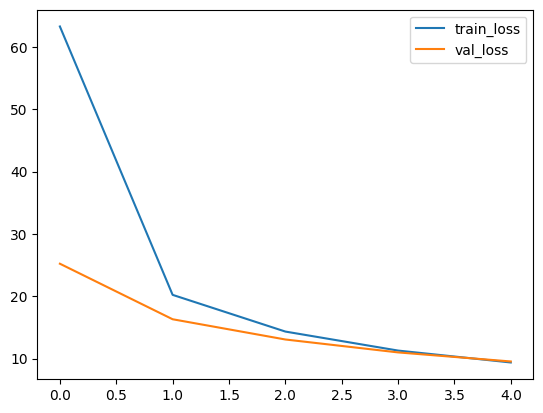

In [18]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

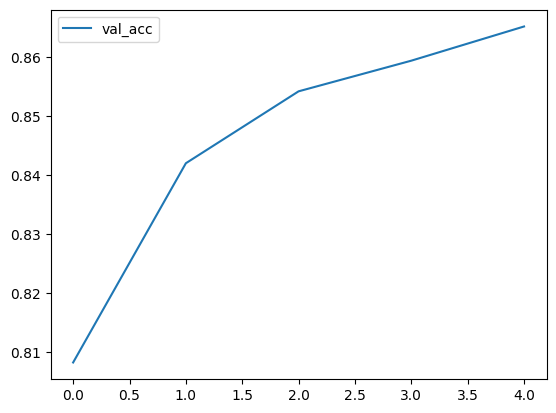

In [19]:
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [20]:
preds = net.predict(x_test)

In [21]:
preds.numpy()

array([7, 2, 1, ..., 4, 8, 6])

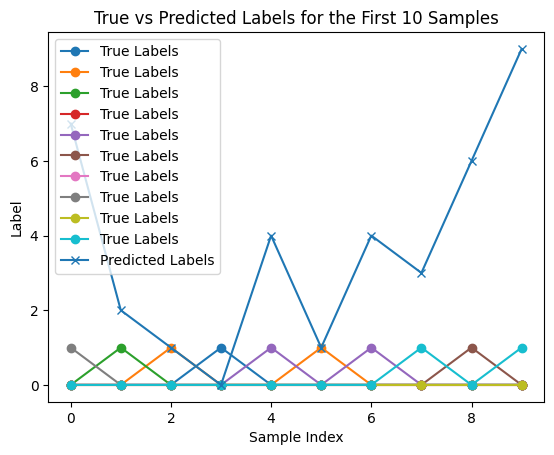

In [22]:


# Assuming both preds and y_test are 1D arrays of class labels
# Plot actual vs predicted labels for the first 10 examples
plt.plot(np.arange(10), y_test[:10], label="True Labels", marker='o')
plt.plot(np.arange(10), preds[:10], label="Predicted Labels", marker='x')
plt.legend()
plt.xlabel("Sample Index")
plt.ylabel("Label")
plt.title("True vs Predicted Labels for the First 10 Samples")
plt.show()


In [23]:
def plot_results(history):
    plt.figure(figsize=(12, 4))
    epochs = len(history['val_loss'])
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), history['val_loss'], label='Val Loss')
    plt.plot(range(epochs), history['train_loss'], label='Train Loss')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), history['val_acc'], label='Val Acc')
    plt.xticks(list(range(epochs)))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt





<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

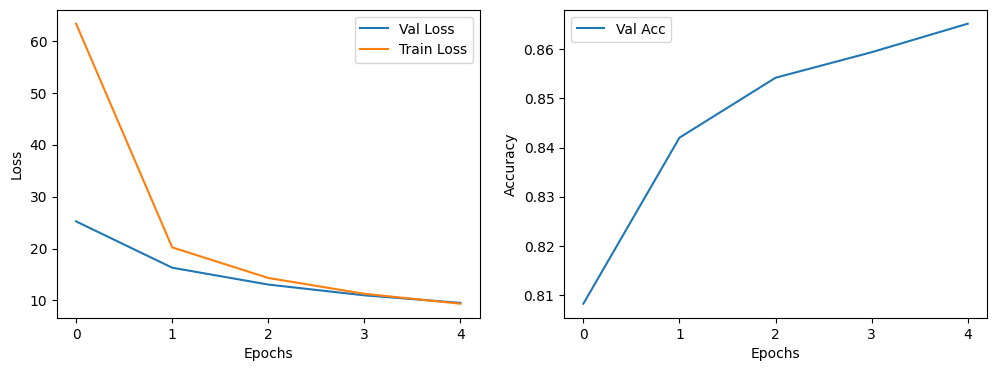

In [24]:
plot_results(history)